In [146]:
import numpy as np

from PIL import Image, ImageDraw, ImageFont

import math

import matplotlib.pyplot as plt

from pdf2image import convert_from_path

from enum import Enum

In [3]:
PPI = 300

pages = convert_from_path(
    'data/李正元2021考研数学一复习全书pdf高清无水印版彩色版.pdf',
    thread_count=12, 
    dpi=PPI,
    fmt='jpeg',
)

In [4]:
def show_sample():
    page = pages[4]
    w, h = page.size
    w >>= 1
    h >>= 1
    page.resize((w, h)).crop((0, 200, w, 600))

In [32]:
h

2071

In [27]:
110 / W

0.07628294036061026

i	y0	y1	p_s	p_e	is_n	is_t	prev_status
0	106	143	106	143	True	False	Status.PROBLEM_START
1	145	159	106	159	False	False	Status.PROBLEM_START
2	172	198	106	198	False	False	Status.PROBLEM_START
3	263	286	106	198	False	True	Status.TITLE
4	310	399	310	399	True	False	Status.PROBLEM_START
5	424	432	310	399	False	False	Status.UNKNOWN
6	424	474	424	474	True	False	Status.PROBLEM_START
7	493	630	493	630	True	False	Status.PROBLEM_START
8	648	681	648	681	True	False	Status.PROBLEM_START
9	700	753	700	753	True	False	Status.PROBLEM_START
10	774	834	774	834	True	False	Status.PROBLEM_START
11	855	857	774	834	False	False	Status.UNKNOWN
12	855	881	855	881	True	False	Status.PROBLEM_START
13	882	884	855	884	False	False	Status.PROBLEM_START
14	887	900	855	900	False	False	Status.PROBLEM_START
15	914	922	855	922	False	False	Status.PROBLEM_START
16	925	980	925	980	True	False	Status.PROBLEM_START
17	992	1249	992	1249	True	False	Status.PROBLEM_START
18	1313	1337	992	1249	False	True	Status.TITLE
19	1358	1381	992	12

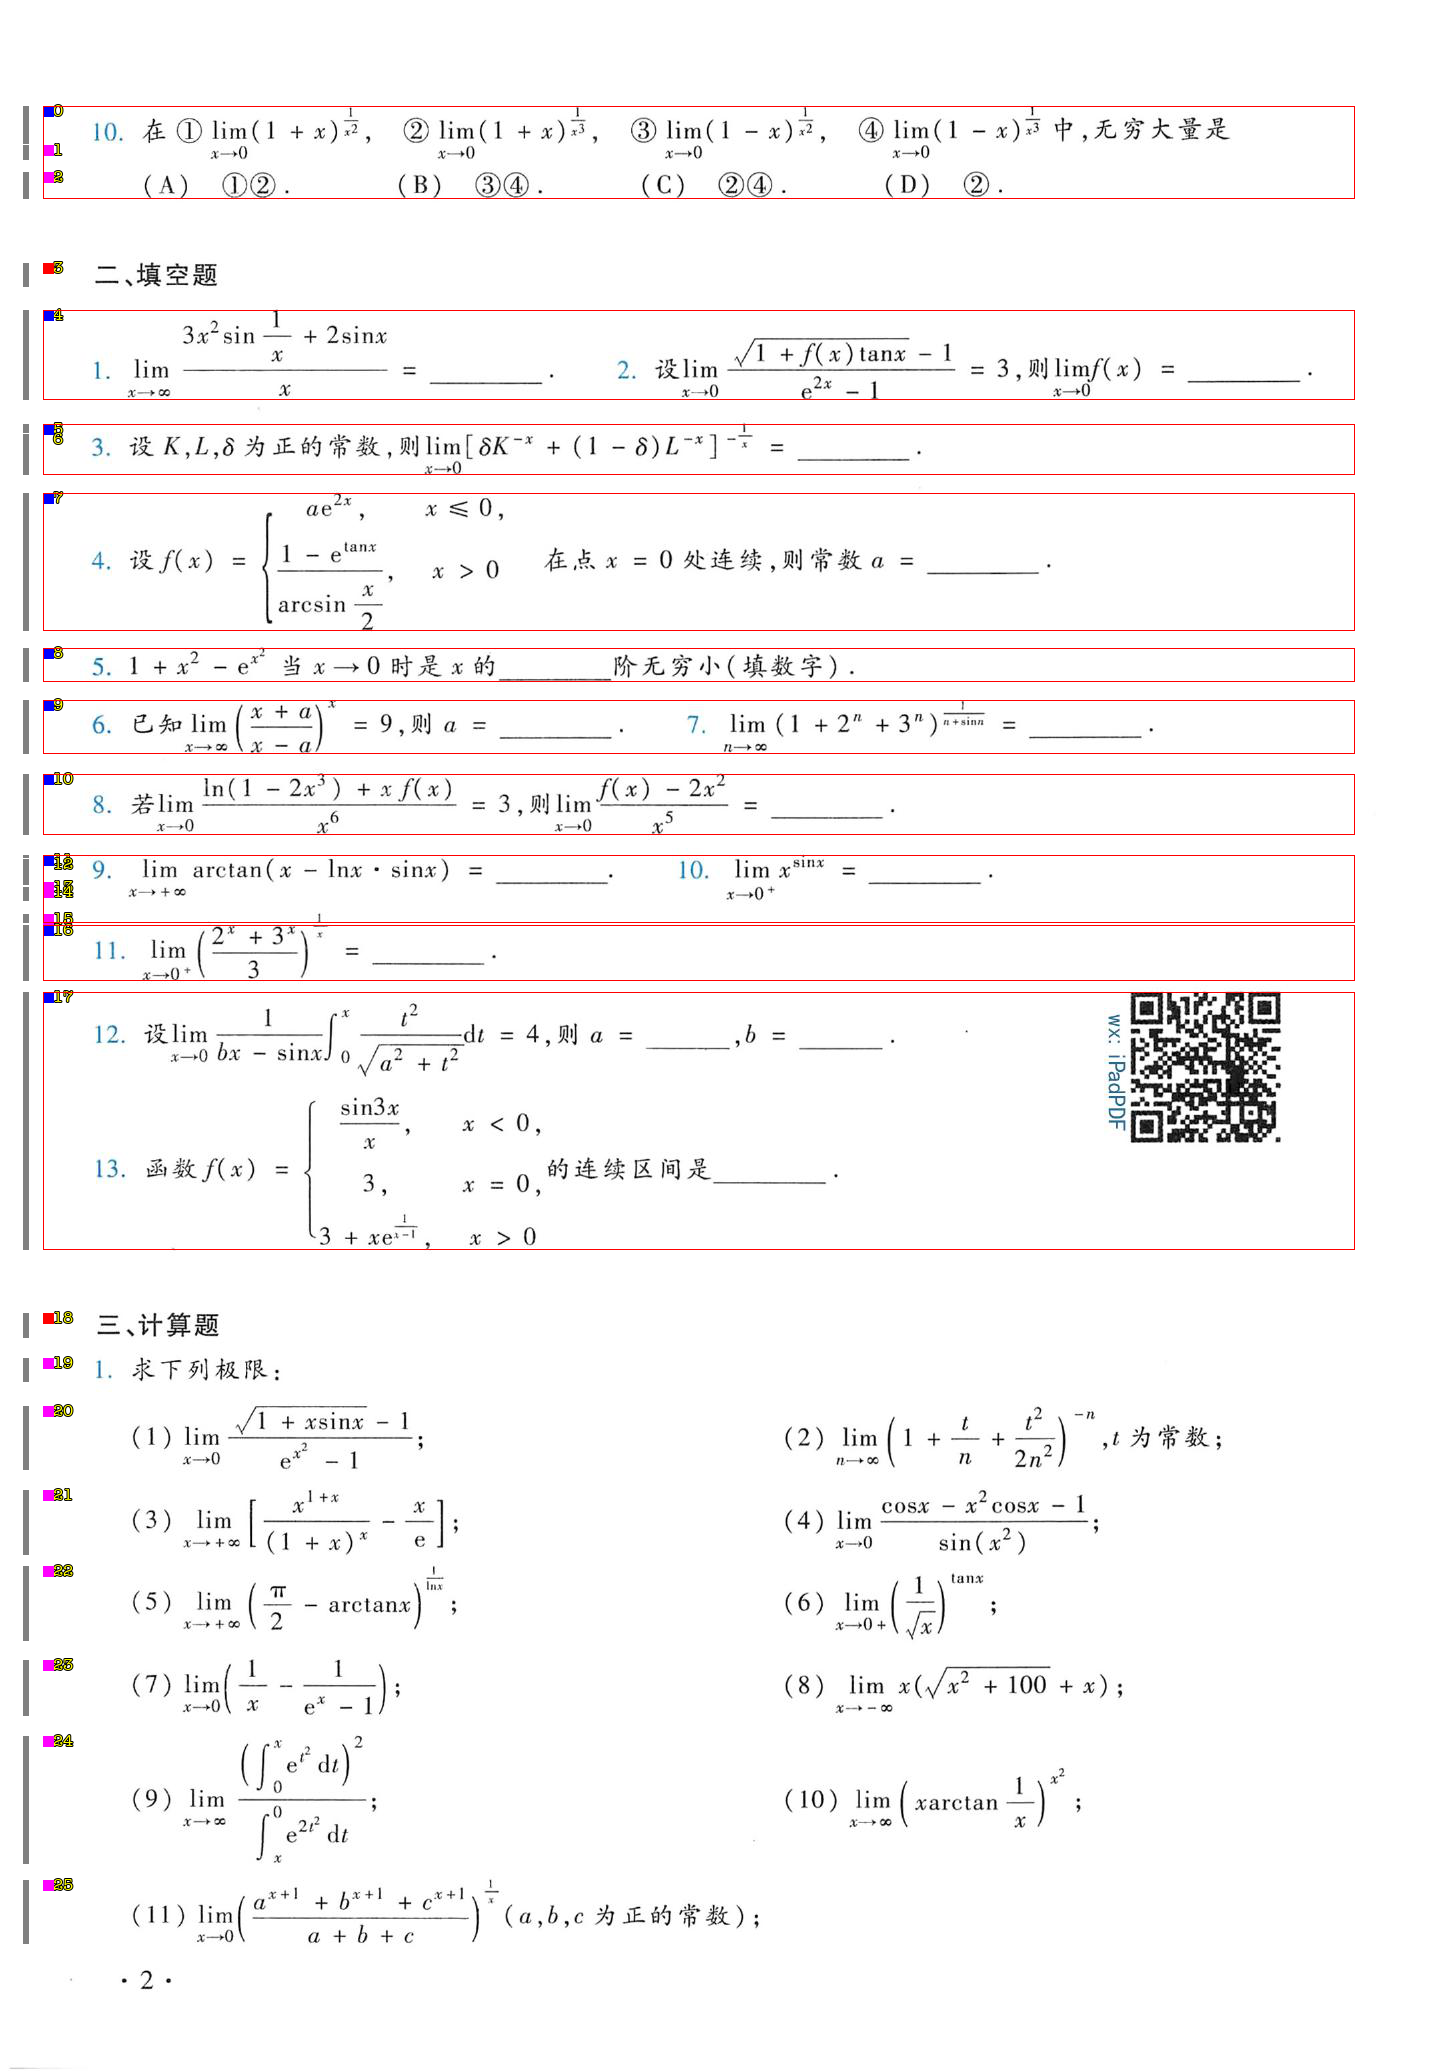

In [178]:
MERGE_PAIRS_UNDER_SAME_PROBLEM = True
PAGE = 5

page = pages[PAGE].copy()
img = ImageDraw.Draw(page)
w, h = page.size
L = int(0.03 * w)
S = 15
PROBLEM_POINT_X = 108
W = 1442; H = 2071; # PPI = 200

class Status(int, Enum):
    NOT_STARTED = 0
    PROBLEM_START = 1
    TITLE = 2
    UNKNOWN = 3

# 这个 p > 150 很重要，可以巧妙分开很多疑似空白的区域
arr_empty = 1 - np.array(page.convert('L').point(lambda p: p > 150))
rows_empty = arr_empty.sum(axis=1) == 0
# limit to the content area, exclude the top, bottom
rows_empty[:int(0.05*h)] = rows_empty[int(0.95*h):] = True
def ensure_blue(p): return p[2] > p[1]
index_rows = np.array(page)[:, int(PROBLEM_POINT_X / W * w)].T
index_rows_empty = np.where(ensure_blue(index_rows), True, False)
index_rows_black = np.array(page.convert('1'))[:, int(PROBLEM_POINT_X / W * w)] == 0 
title_rows_empty = arr_empty[:, int(140 / W * w)]

# pair
k = []; p = True
for i, j in enumerate(rows_empty):
    if j != p:
        k.append(i)
    p = j
assert j == 1 and len(k) % 2 == 0
rect_y_pairs = [(k[2*i], k[2*i+1]) for i in range(len(k) >> 1)]

# merge pairs under the same problem
if MERGE_PAIRS_UNDER_SAME_PROBLEM and rect_y_pairs:
    print('i, y0, y1, p_s, p_e, is_n, is_t, prev_status'.replace(', ', '\t'))
    tmp_ys = []
    prev_status = Status.NOT_STARTED
    p_s, p_e = rect_y_pairs[0]
    for i in range(len(rect_y_pairs)):
        y0, y1 = rect_y_pairs[i]
        img.text((L+10, y0-5), str(i), stroke_fill='black', stroke_width=1, font=ImageFont.truetype(font='/System/Library/Fonts/Supplemental/AmericanTypewriter.ttc', size=16), fill='yellow')
        img.rectangle((L-20, y0, L-15, y1), fill='gray')
        is_n = sum(index_rows_empty[y0: y1]) > 2 # threshold, in case of noise
        is_t = sum(index_rows_black[y0: y1]) > 0 and not is_n

        if is_n:
            if prev_status == Status.UNKNOWN:
                if i > 0 and y0 - rect_y_pairs[i-1][1] < S:
                    y0 = rect_y_pairs[i-1][0]
            if prev_status == Status.PROBLEM_START:
                tmp_ys.append((p_s, p_e))
            p_s = y0
            p_e = y1
            prev_status = Status.PROBLEM_START
            img.rectangle((L, y0, L+10, y0+10), fill="blue")

        elif is_t: # 标题行（四、证明题），直接忽视
            if prev_status == Status.PROBLEM_START:
                tmp_ys.append((p_s, p_e))
            prev_status = Status.TITLE
            img.rectangle((L, y0, L+10, y0+10), fill="red")

        else:
            if prev_status == Status.NOT_STARTED:
                prev_status = Status.PROBLEM_START
            if prev_status == Status.PROBLEM_START:
                if i == 0 or y0 - rect_y_pairs[i-1][1] < S:
                    p_e = y1
                else:
                    prev_status = Status.UNKNOWN
                    tmp_ys.append((p_s, p_e))
            img.rectangle((L, y0, L+10, y0+10), fill="magenta")
        
        print(i, y0, y1, p_s, p_e, is_n, is_t, prev_status, sep='\t')
                
    tmp_ys.append((p_s, p_e))
    rect_y_pairs = tmp_ys

# draw problem content
for y0, y1 in rect_y_pairs:
    img.rectangle((L, y0, w-L*2, y1), outline='red')
    
page

## interactive handler

<IPython.core.display.Javascript object>


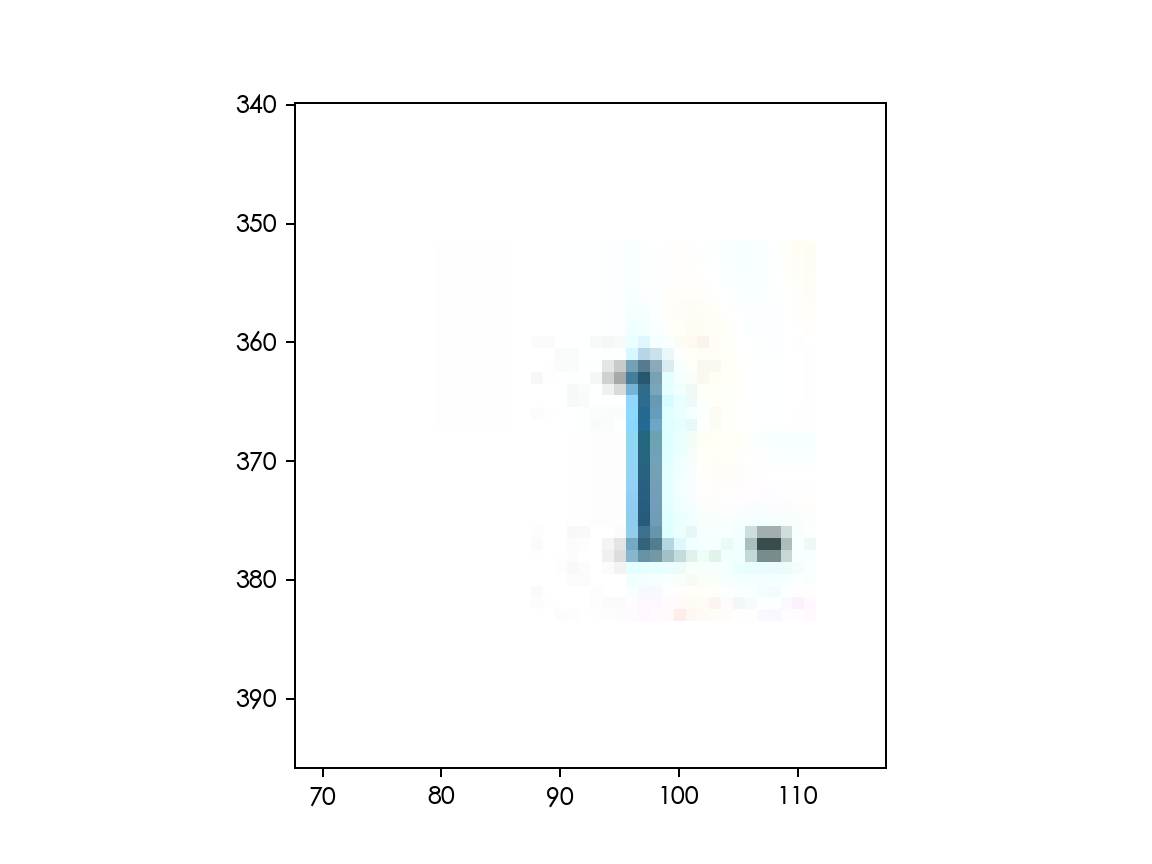

In [114]:
%matplotlib notebook
plt.imshow(pages[5])